# Import libs

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import giotto
import sklearn as skl
import plotly
import seaborn as sns
sns.set()

import plotting
import topo

from scipy import signal
from giotto.time_series import Resampler, TakensEmbedding
from giotto.homology import VietorisRipsPersistence
from giotto.diagrams import Filtering, PairwiseDistance, BettiCurve, PersistenceLandscape, Amplitude, HeatKernel
from giotto.diagrams._utils import _subdiagrams
from giotto.pipeline import Pipeline
from sklearn.manifold import smacof
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, cohen_kappa_score
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import normalize, StandardScaler, MinMaxScaler

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Import data

In [144]:
x = pd.read_csv('training_un7FCmp.csv')
y = pd.read_csv('target_ATndViR.csv')
xtest = pd.read_csv('input_test_YW07KeM.csv')

x_nid = x[['neuron_id']]
y_label = y[['TARGET']].rename(columns={'TARGET': 'label'})

xy = x.merge(y, on='ID')

npx = x.values
npy = y.values
npx_test = xtest.values

intervals = npx[:, 3:] - npx[:, 2:-1]
intervals_test = npx_test[:,3:] - npx_test[:, 2:-1]

def intervals_to_df(intervals):
    return pd.DataFrame(data=intervals, columns=pd.Index(['interval_%s' % n for n in range(49)])).stack().reset_index().rename(columns={'level_0':'id', 'level_1': 'time', 0:'x'})

df_intervals = intervals_to_df(intervals)
df_intervals_test = intervals_to_df(intervals_test)

# Stats

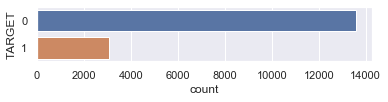

Mean labels balance (0 over 1): 4.439829954218443
# of unique neurons (train): 458
# of unique neurons (test): 113
Train size: 16635
Test size: 11969
Average # of samples per neuron: 36
Average # of samples per neuron in test: 105
Samples per neuron distribution in train and test


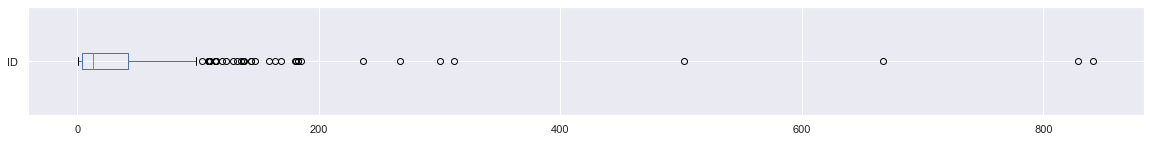

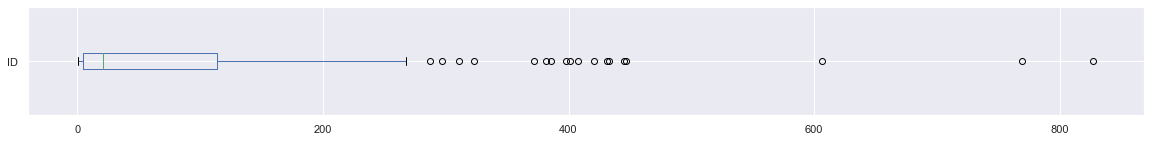

In [4]:
plt.figure(figsize=(6, 1))
sns.countplot(y="TARGET", data=xy)
plt.show()
target_cnt = xy.groupby('TARGET').count()
label_0_cnt = target_cnt.ID[0]
label_1_cnt = target_cnt.ID[1]
print(f'Mean labels balance (0 over 1): {label_0_cnt / label_1_cnt}')

nunique_nid = x.neuron_id.nunique()
nunique_nid_test = xtest.neuron_id.nunique()
print(f'# of unique neurons (train): {nunique_nid}')
print(f'# of unique neurons (test): {nunique_nid_test}')

train_len = len(x)
test_len = len(xtest)

print(f'Train size: {train_len}')
print(f'Test size: {test_len}')

print(f'Average # of samples per neuron: {int(train_len / nunique_nid)}')
print(f'Average # of samples per neuron in test: {int(test_len / nunique_nid_test)}')

print('Samples per neuron distribution in train and test')
plt.figure(figsize=(20, 2))
x.groupby('neuron_id').count()[['ID']].boxplot(vert=False)
plt.show()
plt.figure(figsize=(20, 2))
xtest.groupby('neuron_id').count()[['ID']].boxplot(vert=False)
plt.show()

# Time-series visualisation

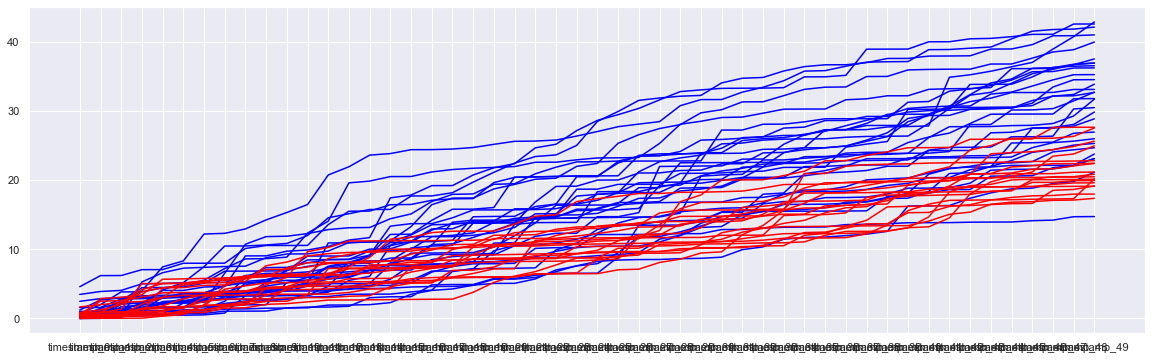

Random neurons


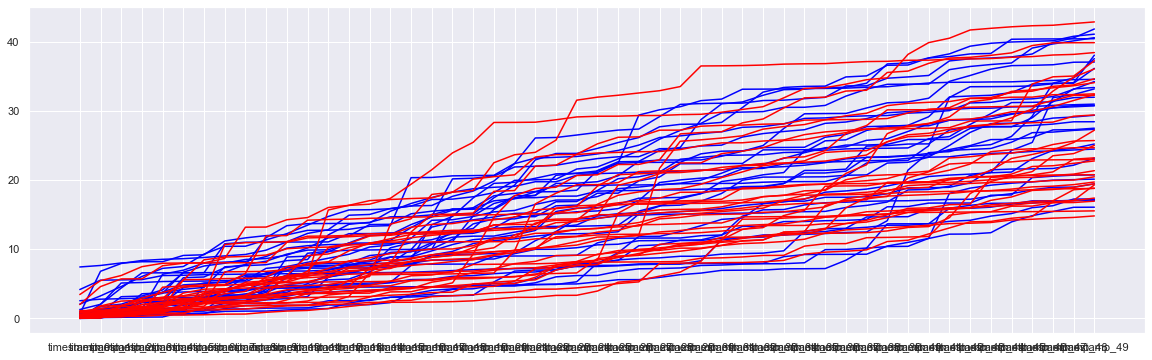

In [349]:
neuron_id = 596
# 596  = good sep
# 6156 = messy
# 2341 = ultra messy
# 7770 = good separation on 30 samples, takes time

nid_filter = x_nid.neuron_id == neuron_id

n_ts = 30
topo.plot_raw_ts(xy, neuron_id, n_ts, False)

print('Random neurons')
topo.plot_raw_ts(xy, -1, n_ts)

# Preprocessing

## KDE

Standard dev: 5.0


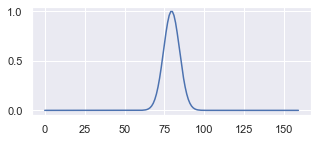

Minimum spike interval: 0.0011646282981550016
Max last spike timestamp: 430
Minimum right limit: 590


In [8]:
bigm = 160 # Number of points in the output window #good: 32k, 32
std = bigm/32
print(f'Standard dev: {std}')
window = signal.gaussian(bigm, std=std)
plt.figure(figsize=(5, 2))
plt.plot(window)
plt.show()

# Rescaling to avoid perfect collapsing spike due to integer spacing
scale = 10
print(f'Minimum spike interval: {df_intervals.x.min()}')

max_last_ts = int(xy.timestamp_49.max() * scale)
min_right_lim = max_last_ts + bigm
print(f'Max last spike timestamp: {max_last_ts}')
print(f'Minimum right limit: {min_right_lim}')

In [ ]:
%%time
samples_per_label = 30 #150
full_dataset = False
plot_sum = False
plot_spikes = True

# filter by neuron_id
if full_dataset:
    xy_filtered = xy
else:
    xy_filtered = xy[nid_filter]

x_np = xy_filtered.values[:, 2:-1]
y_np = xy_filtered.values[:, -1:]

n_curves = 3
# topo.plot_raw_ts(xy, neuron_id, n_curves, separate=False)

print('Creating gaussian spikes')
x_gaus = topo.gaus_kde(x_np, window, min_right_lim, bigm, scale)

print('Resampling')
period = 2
resamp = Resampler(period=period)
x_resamp = resamp.fit_transform(x_gaus.T).T

if plot_spikes:
    print('Plotting gaussian spikes')
    topo.plot_gaus_kde(x_resamp, y_np, 1, 1, samefig=True)

if plot_sum:
    print('Plotting gaussian spikes sum')
    topo.plot_gaus_kde_sum(x_resamp, y_np, xy_filtered, scale)

# Extract topological features

## Apply TDA pipeline

### KDE, Takens embedding

Creating gaussian spikes
Resampling
Plotting gaussian spikes


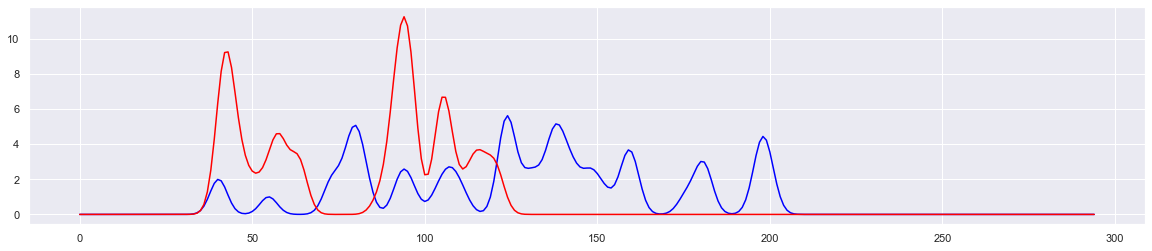

Creating Takens Embedding
CPU times: user 644 ms, sys: 14.1 ms, total: 658 ms
Wall time: 654 ms


In [11]:
print('Creating Takens Embedding')
te = TakensEmbedding(time_delay=1, dimension=3, parameters_type='fixed')
x_tak = np.apply_along_axis(te.fit_transform, 1, x_resamp)

### Persistence diagrams

In [12]:
%%time
compute_pd = False
save_pd = False
load_pd = True

if compute_pd:
    print('Creating V-R Persistence Diagrams')
    homology_dimensions = [0, 1]
    vrp = VietorisRipsPersistence(max_edge_length=20, homology_dimensions=homology_dimensions, n_jobs=-1)
    x_vrpd = vrp.fit_transform(x_tak)

    if save_pd:
        np.save('x_vrpd_4.npy', x_vrpd)
    
if load_pd:
    # Load precomputed x_vrpd on the whole dataset
    x_vrpd = np.load('x_vrpd_4.npy')

CPU times: user 1.12 ms, sys: 42.4 ms, total: 43.5 ms
Wall time: 49.3 ms


### Pairwise distances, MDS

In [13]:
%%time
filter_diagrams = False
pw_distances = False

# need scaling first
if filter_diagrams:
    print('Filtering diagrams')
    ftr = Filtering(homology_dimensions=homology_dimensions, epsilon=0.01)
    x_vrpd = ftr.fit_transform(x_vrpd)

if pw_distances:
    print('Compute pairwise distances')
    pwd = PairwiseDistance(metric='betti', n_jobs=-1) # betti, heat > landscape (wasserstein non symmetric)
    x_dists = pwd.fit_transform(x_vrpd)

    print('Plotting betti distances')
    x_mds = smacof(x_dists, n_components=2, n_jobs=-1)
    plt.figure(figsize=(5, 5))
    plt.scatter(x_mds[0][y_0, 0], x_mds[0][y_0, 1], c='blue')
    plt.scatter(x_mds[0][y_1, 0], x_mds[0][y_1, 1], c='red')
    plt.show()

    print('Compute pairwise distances')
    pwd = PairwiseDistance(metric='heat', n_jobs=-1) # betti, heat > landscape (wasserstein non symmetric)
    x_dists = pwd.fit_transform(x_vrpd)

    print('Plotting heat distances')
    x_mds = smacof(x_dists, n_components=2, n_jobs=-1)
    plt.figure(figsize=(5, 5))
    plt.scatter(x_mds[0][y_0, 0], x_mds[0][y_0, 1], c='blue')
    plt.scatter(x_mds[0][y_1, 0], x_mds[0][y_1, 1], c='red')
    plt.show()

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 6.91 µs


### Betti curves

In [14]:
%%time
n_values_bc = 2000
bc = BettiCurve(n_values=n_values_bc, n_jobs=-1)
bcs = bc.fit_transform(x_vrpd)
# plotting.plot_betti_surfaces(bcs)

CPU times: user 1.9 s, sys: 1.74 s, total: 3.64 s
Wall time: 15.7 s


In [15]:
X_betti_0_full = pd.DataFrame(bcs[:, 0])
X_betti_1_full = pd.DataFrame(bcs[:, 1])

## Sub-features experiments

### Plot betti curves

In [18]:
df_0 = pd.DataFrame(bcs[:, 0]).rename_axis('sample').reset_index().melt(id_vars=['sample'], var_name='time', value_name='betti_number_0').set_index(['sample', 'time'], append=True)
df_1 = pd.DataFrame(bcs[:, 1]).rename_axis('sample').reset_index().melt(id_vars=['sample'], var_name='time', value_name='betti_number_1').set_index(['sample', 'time'], append=True)

melted_bn = pd.concat([df_0, df_1], axis=1).reset_index(['sample', 'time']).merge(x_nid.join(y_label).rename_axis('sample').reset_index())

In [19]:
time_range_0 = 80
time_range_1 = 150
#bn0_df_label = pd.DataFrame(bcs[:, 0, :time_range_0]).join(y_label)
#bn1_df_label = pd.DataFrame(bcs[:, 1, :time_range_1]).join(y_label)
bn0_df_label = pd.DataFrame(bcs[:, 0]).join(y_label)
bn1_df_label = pd.DataFrame(bcs[:, 1]).join(y_label)

/Users/philippenguyen/code/topollini/venv/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.



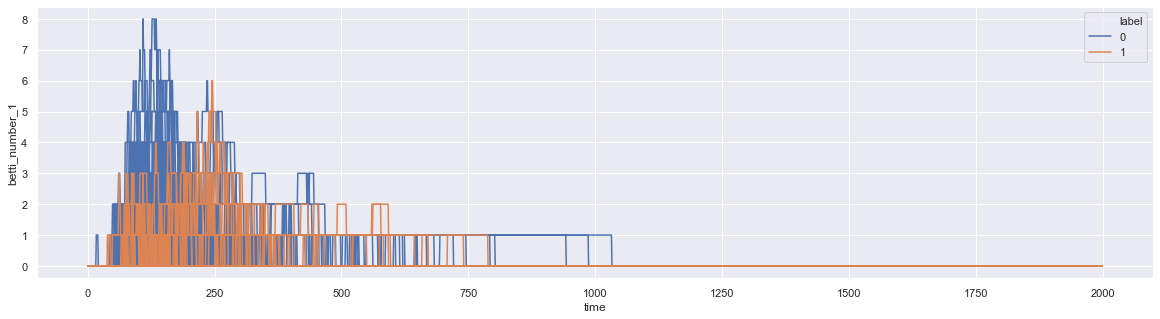

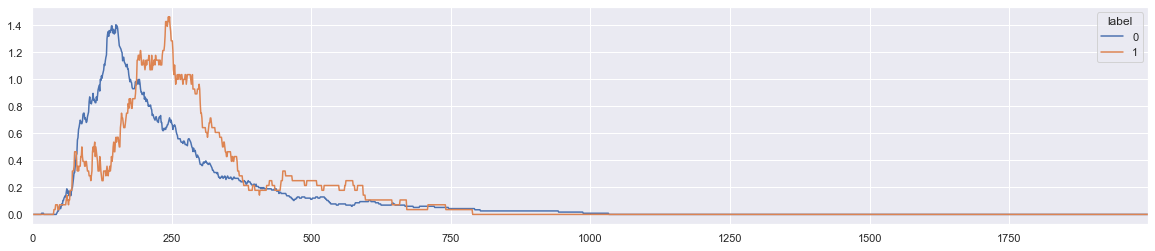

In [29]:
melted_bn_nid = melted_bn[melted_bn.neuron_id == neuron_id]
melted_bn1_nid = melted_bn_nid #[melted_bn.time < 500]
plt.figure(figsize=(20, 5))
sns.lineplot(x="time", y="betti_number_1",
             hue="label", units='sample', estimator=None,
             data=melted_bn1_nid)
plt.show()
bn1_df_label[nid_filter].groupby('label').mean().T.plot(figsize=(20, 4))
plt.show()

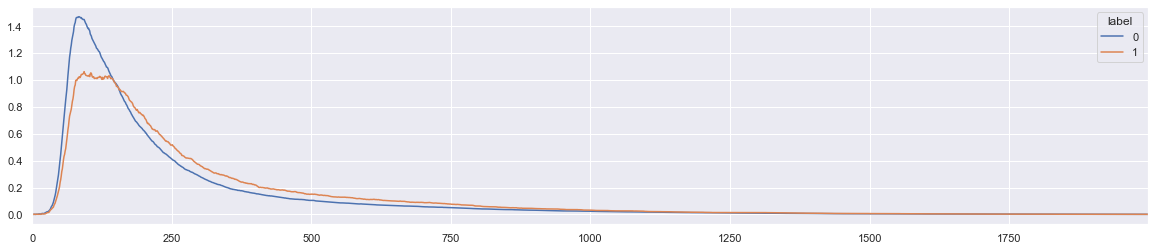

In [21]:
bn1_df_label.groupby('label').mean().T.plot(figsize=(20, 4))
plt.show()

/Users/philippenguyen/code/topollini/venv/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



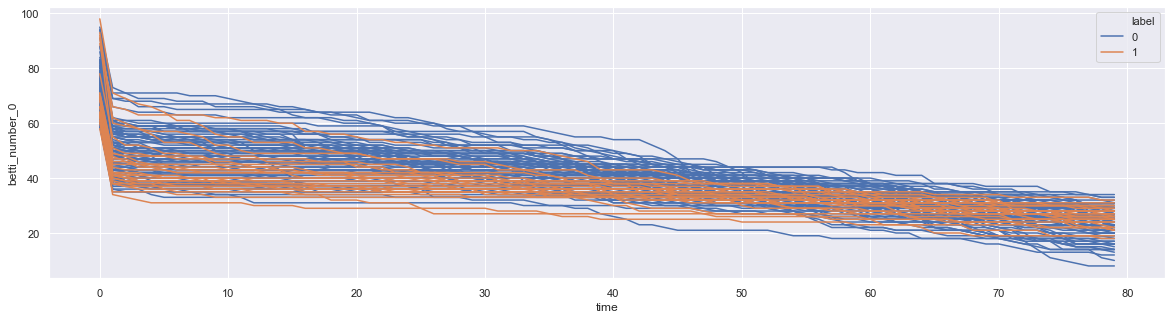

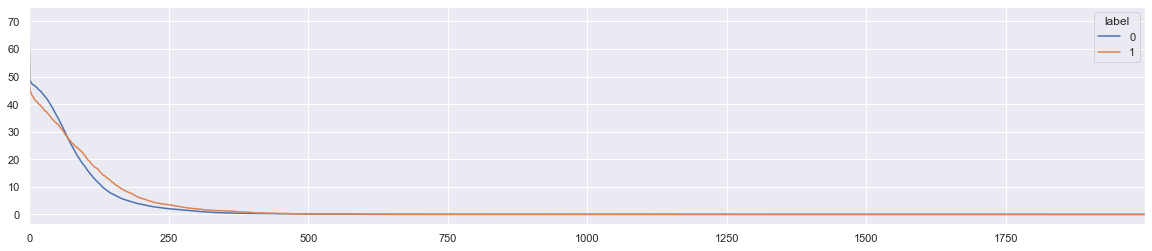

In [22]:
melted_bn0_nid = melted_bn_nid[melted_bn.time < time_range_0]
plt.figure(figsize=(20, 5))
sns.lineplot(x="time", y="betti_number_0",
             hue="label", units='sample', estimator=None,
             data=melted_bn0_nid)
plt.show()
bn0_df_label[nid_filter].groupby('label').mean().T.plot(figsize=(20, 4))
plt.show()

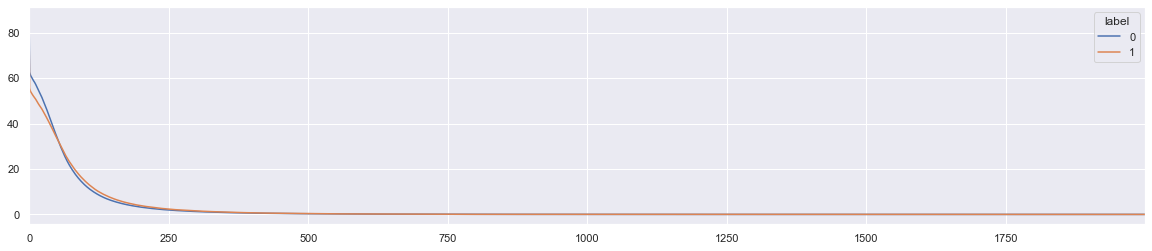

In [23]:
bn0_df_label.groupby('label').mean().T.plot(figsize=(20, 4))
plt.show()

### Area under the curve

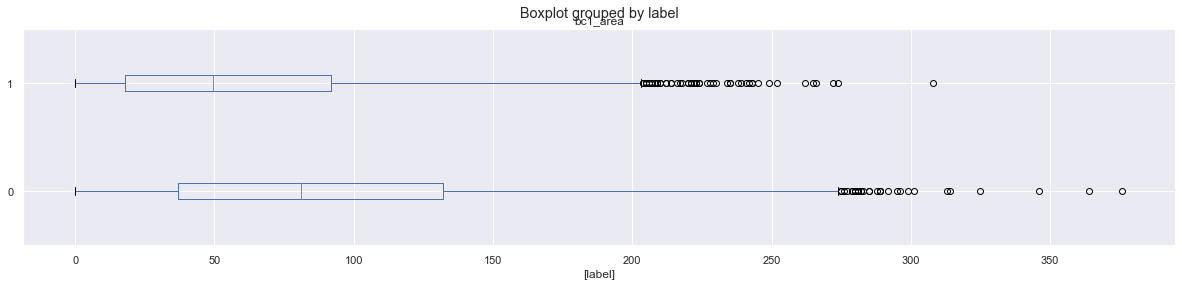

In [24]:
sum_range = 120 #30
X_betti_1 = pd.DataFrame(bcs[:, 1, 0:sum_range])
X_sum1 = pd.DataFrame(X_betti_1.sum(axis=1), columns=['bc1_area']).join(y_label).join(x_nid)
# X_sum1 = X_sum1[X_sum1.neuron_id == neuron_id]
X_sum1[['bc1_area','label']].boxplot(by='label', vert=False, figsize=(20, 4))
plt.show()

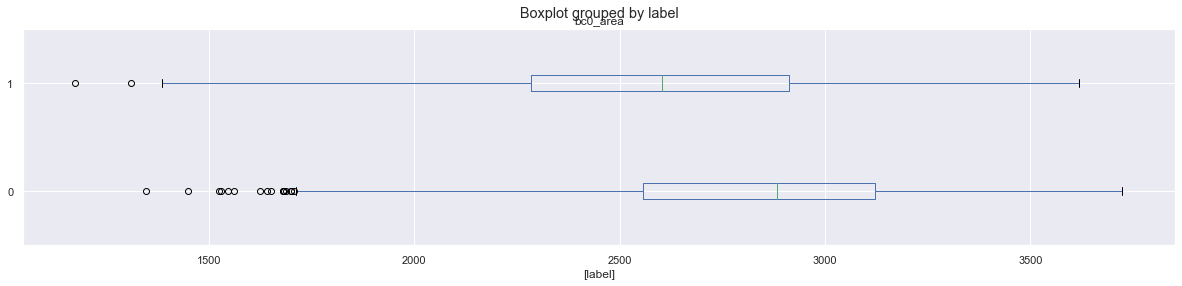

In [25]:
X_betti_0 = pd.DataFrame(bcs[:, 0, 0:60])
X_sum0 = pd.DataFrame(X_betti_0.sum(axis=1), columns=['bc0_area']).join(y_label).join(x_nid)
# X_sum0 = X_sum0[X_sum0.neuron_id == neuron_id]
X_sum0[['bc0_area','label']].boxplot(by='label', vert=False, figsize=(20, 4))
plt.show()

In [26]:
lim_all = 40 #35 dichotomy (17 nid)
X_sum1['manual_clf'] = X_sum1.apply(lambda x: 1.0 if x.bc1_area < lim_all else 0.0, axis = 1)
print(confusion_matrix(X_sum1.manual_clf, X_sum1.label))
print(cohen_kappa_score(X_sum1.manual_clf, X_sum1.label))

[[9978 1761]
 [3599 1297]]
0.12901381090363873


In [27]:
lim_all = 2545 #1167 dichotomy (1250 for nid)
X_sum0['manual_clf'] = X_sum0.apply(lambda x: 1.0 if x.bc0_area < lim_all else 0.0, axis = 1)
print(confusion_matrix(X_sum0.manual_clf, X_sum0.label))
print(cohen_kappa_score(X_sum0.manual_clf, X_sum0.label))

[[10275  1662]
 [ 3302  1396]]
0.17661071864843125


In [28]:
bc_area = X_sum1[['bc1_area']].join(X_sum0[['bc0_area']])

### Adcock et al. Coordinates

In [30]:
def yi_minus_xi(X):
    return X[:, :, 1] - X[:, :, 0]

Pxi(yi − xi)

In [31]:
def feature_1(X, dim):
    X = _subdiagrams(X, [dim])
    return np.sum((X[:, :, 0] * yi_minus_xi(X)), axis=1) / X.shape[1]

P(ymax − yi)(yi − xi)

In [32]:
def feature_2(X, dim):
    X = _subdiagrams(X, [dim])
    return np.sum((np.max(X[:, :, 1], axis=1).reshape((X.shape[0], 1)) - X[:, :, 1]) * (yi_minus_xi(X)), axis=1) / X.shape[1]

Pxi2(yi − xi)4

In [33]:
def feature_3(X, dim):
    X = _subdiagrams(X, [dim])
    return np.sum(((X[:, :, 0]**2) * (yi_minus_xi(X)**4)), axis=1) / X.shape[1]

P(ymax − yi)2(yi − xi)4

In [34]:
def feature_4(X, dim):
    X = _subdiagrams(X, [dim])
    return np.sum(((np.max(X[:, :, 1], axis=1).reshape((X.shape[0], 1)) - X[:, :, 1])**2) * (yi_minus_xi(X)**4), axis=1) / X.shape[1]

max{(yi − xi)}

In [35]:
def feature_5(X, dim):
    X = _subdiagrams(X, [dim])
    return np.max(yi_minus_xi(X), axis=1) / X.shape[1]

In [36]:
fts_func = [feature_1, feature_2, feature_3, feature_4, feature_5]
fts = {}
for feature_number in range(5):
    for dim in range(2):
        fts[f'f{feature_number}_d{dim}'] = fts_func[feature_number](x_vrpd, dim)

In [37]:
tropical = pd.DataFrame(fts)

### Landscapes (WIP)

In [139]:
pl = PersistenceLandscape(n_jobs=-1, n_layers=3)
x_pl = pl.fit_transform(x_vrpd_full)

In [124]:
x_pl.shape

(16635, 2, 1, 100)

### Amplitude

In [38]:
amp = Amplitude(metric='heat', metric_params=None, order=2.0, n_jobs=-1)
# x_amp = amp.fit_transform(x_vrpd)

In [75]:
amps = {}
for metric in ['bottleneck', 'wasserstein', 'landscape', 'betti', 'heat']:
    print(metric)
    amp = Amplitude(metric=metric, metric_params=None, n_jobs=-1)
    x_amp = amp.fit_transform(x_vrpd)
    amps[metric] = x_amp.ravel()
    # plt.figure(figsize=(20, 6))
    # pd.DataFrame(amps[metric], columns=[metric]).join(y_label).groupby('label')[metric].plot.kde()
    # plt.show()
# .boxplot(by='label')

bottleneck
wasserstein
landscape
betti
heat


In [78]:
amplitudes = pd.DataFrame(amps)

### Gaussian kernel (WIP)

In [132]:
hk = HeatKernel(8., n_values=100, n_jobs=-1)
x_hk = hk.fit_transform(x_vrpd_full)

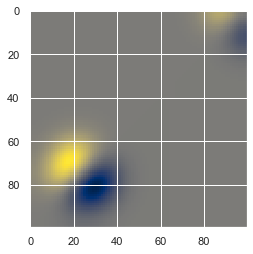

In [134]:
plt.imshow(x_hk[0, 1], cmap='cividis')
plt.show()

### Moments

In [41]:
m_1 = np.sum(normalize(bcs[:, 1], norm='max', axis=1) * np.power(np.arange(2000), 1), axis=1)
m_2 = np.sum(normalize(bcs[:, 1], norm='max', axis=1) * np.power(np.arange(2000), 2), axis=1)

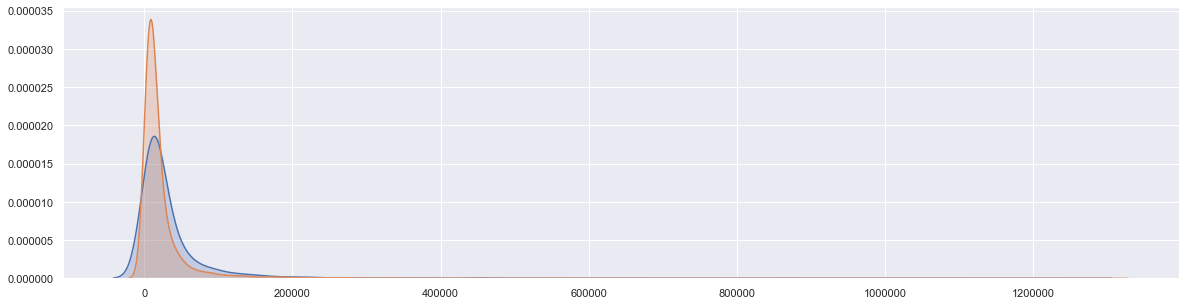

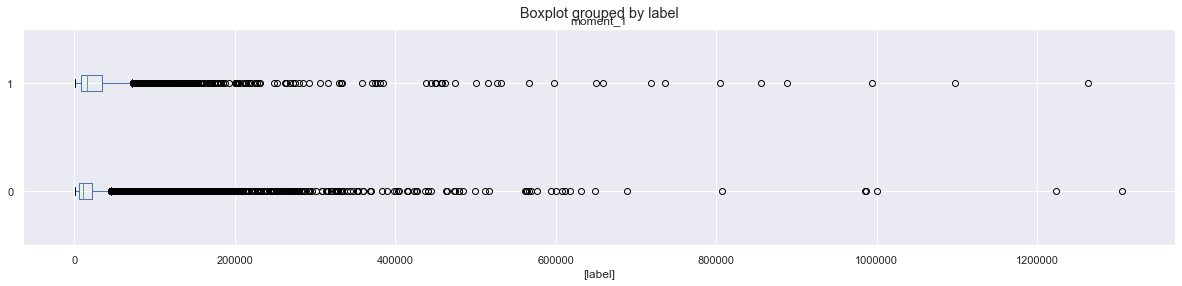

In [42]:
plt.figure(figsize=(20, 5))
select_nid = x_nid.neuron_id == neuron_id

sns.kdeplot(pd.DataFrame(m_1, columns=['moment_1'])[y_label.label==1].moment_1.values, shade=True, gridsize=1000)
sns.kdeplot(pd.DataFrame(m_1, columns=['moment_1'])[y_label.label==0].moment_1.values, shade=True, gridsize=1000)
plt.show()

pd.DataFrame(m_1, columns=['moment_1']).join(y_label).boxplot(by='label', vert=False, figsize=(20, 4))
plt.show()

In [47]:
mdf1 = pd.DataFrame(m_1, columns=['moment_1']).join(y_label)[x_nid.neuron_id == neuron_id]
thm1 = 19000
mdf1['manual_clf'] = mdf1.apply(lambda x: 1.0 if x.moment_1 > thm1 else 0.0, axis = 1)
print(confusion_matrix(mdf1.manual_clf, mdf1.label))
print(cohen_kappa_score(mdf1.manual_clf, mdf1.label))

[[75  9]
 [41 19]]
0.2268041237113403


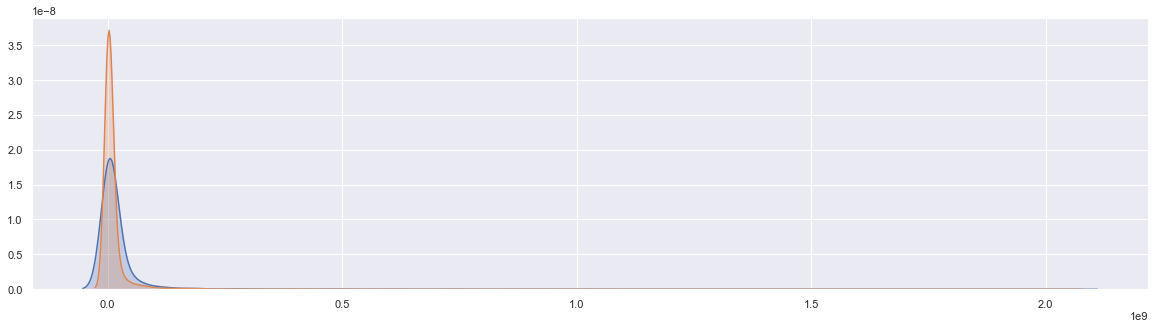

In [44]:
plt.figure(figsize=(20, 5))

sns.kdeplot(pd.DataFrame(m_2, columns=['moment_2'])[y_label.label==1].moment_2.values, shade=True, gridsize=1000)
sns.kdeplot(pd.DataFrame(m_2, columns=['moment_2'])[y_label.label==0].moment_2.values, shade=True, gridsize=1000)
plt.show()


In [82]:
moments = {
    'moment_1': m_1,
    'moment_2': m_2,
}
moments_df = pd.DataFrame(moments)

### Cumulative sum

In [61]:
cumsum_range = 200
X_betti_cs_1 = pd.DataFrame(bcs[:, 1, 25:cumsum_range])

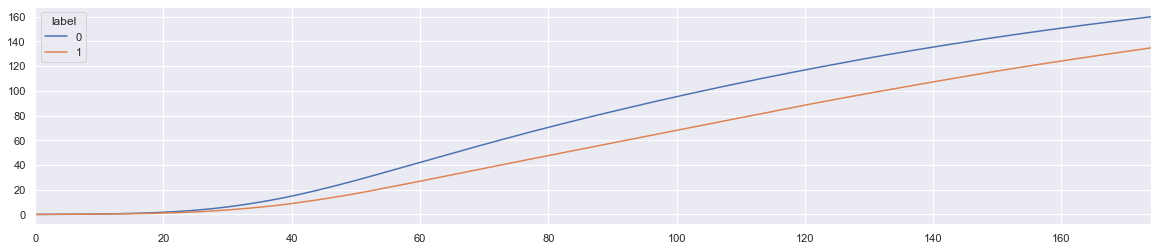

In [52]:
X_cumsum = X_betti_cs_1.cumsum(axis=1).join(y_label).join(x_nid) #[x_nid.neuron_id == neuron_id]
X_cumsum.groupby('label').mean().drop('neuron_id', axis=1).T.plot(figsize=(20, 4))
plt.show()

In [57]:
mmm = 0
for j in range(110, 130):
    for i in range(60, 80):
        X_cumsum['manual_clf'] = X_cumsum.apply(lambda x: 1.0 if x[j] < i else 0.0, axis = 1)
        # print(confusion_matrix(X_cumsum.manual_clf, X_cumsum.label))
        # print(cohen_kappa_score(X_cumsum.manual_clf, X_cumsum.label))
        if cohen_kappa_score(X_cumsum.manual_clf, X_cumsum.label) > mmm:
            mmm = cohen_kappa_score(X_cumsum.manual_clf, X_cumsum.label)
            besti = i
            bestj = j
            
print(mmm)
print(besti)
print(bestj)

0.13776448330640623
69
129


In [58]:
X_cumsum['manual_clf'] = X_cumsum.apply(lambda x: 1.0 if x[129] < 69 else 0.0, axis = 1)
cohen_kappa_score(X_cumsum.manual_clf, X_cumsum.label)

0.13776448330640623

# Classification

In [350]:
# Join all topological features
topo_features = bc_area.join(tropical).join(amplitudes).join(moments_df).join(X_betti_cs_1[[129]]).drop(columns=['f0_d0', 'f2_d0'])

In [351]:
# Rescaling
scaler = MinMaxScaler()
topo_features[topo_features.columns] = scaler.fit_transform(topo_features[topo_features.columns])
topo_features.head()

,bc1_area,bc0_area,f0_d1,f1_d0,f1_d1,f2_d1,f3_d0,f3_d1,f4_d0,f4_d1,bottleneck,wasserstein,landscape,betti,heat,moment_1,moment_2,129
0,0.000000,0.401569,0.134783,0.574225,0.422493,8.391752e-05,0.009059,4.778804e-03,0.425627,0.109392,0.460094,0.463140,0.300126,0.721942,0.370011,0.028287,0.011791,0.000000
1,0.090426,0.404706,0.044093,0.103409,0.050716,2.818791e-06,0.000117,2.623091e-05,0.124877,0.058767,0.139179,0.211030,0.048333,0.782478,0.730420,0.019774,0.003571,0.142857
2,0.672872,0.865882,0.018126,0.085657,0.015449,5.898444e-08,0.000009,9.785859e-08,0.080255,0.033815,0.250131,0.279644,0.128910,0.764763,0.684575,0.001951,0.000135,0.000000
3,0.140957,0.396078,0.047821,0.045186,0.049075,4.930464e-06,0.000014,2.196862e-05,0.077479,0.085722,0.159517,0.211025,0.060252,0.904305,0.789160,0.014698,0.002126,0.142857
4,0.058511,0.540784,0.051868,0.279613,0.095691,4.939743e-06,0.000888,3.526508e-05,0.232504,0.069769,0.143641,0.248665,0.052965,0.741743,0.579396,0.014957,0.002697,0.142857


In [307]:
# Join with tsfresh features
tsfresh_features = pd.read_pickle("tsfresh_features.pkl")
topo_features = topo_features.join(tsfresh_features)

In [357]:
# Under-sampling
tf_us = topo_features.join(y_label).groupby('label').head(3000)

In [358]:
X_train, X_test, y_train, y_test = train_test_split(tf_us.drop(columns=['label']), tf_us.label.values, test_size=0.2, random_state=42)

In [359]:
log_clf = LogisticRegression(solver="liblinear")
log_clf.fit(X_train, y_train)
preds = log_clf.predict(X_test)
print('\nLogisticRegression')
print(confusion_matrix(y_test, preds))
print(cohen_kappa_score(y_test, preds))

sgd_clf = SGDClassifier(n_jobs=-1, max_iter=2000)
sgd_clf.fit(X_train, y_train)
preds = sgd_clf.predict(X_test)
print('\nSGDClassifier')
print(confusion_matrix(y_test, preds))
print(cohen_kappa_score(y_test, preds))

svc = LinearSVC(max_iter=5000)
# svc.fit(X_train, y_train)
# preds = svc.predict(X_test)
# print('\nLinearSVC')
# print(confusion_matrix(y_test, preds))
# print(cohen_kappa_score(y_test, preds))

mlp = MLPClassifier(max_iter=300)
mlp.fit(X_train, y_train)
preds = mlp.predict(X_test)
print('\nMLPClassifier')
print(confusion_matrix(y_test, preds))
print(cohen_kappa_score(y_test, preds))

rf = RandomForestClassifier(n_estimators=1000) #, class_weight={0: 4.439, 1: 1}
rf.fit(X_train, y_train)
preds = rf.predict(X_test)
print('\nRandomForestClassifier')
print(confusion_matrix(y_test, preds))
print(cohen_kappa_score(y_test, preds))

gnb = GaussianNB()
gnb.fit(X_train, y_train)
preds = gnb.predict(X_test)
print('\nGNB')
print(confusion_matrix(y_test, preds))
print(cohen_kappa_score(y_test, preds))

kn = KNeighborsClassifier(3)
kn.fit(X_train, y_train)
preds = kn.predict(X_test)
print('\nKNN')
print(confusion_matrix(y_test, preds))
print(cohen_kappa_score(y_test, preds))


LogisticRegression
[[389 234]
 [227 350]]
0.2308804555768118

SGDClassifier
[[425 198]
 [263 314]]
0.22732250206717763

MLPClassifier
[[381 242]
 [217 360]]
0.23509773751131802

RandomForestClassifier
[[375 248]
 [218 359]]
0.22368052065603994

GNB
[[543  80]
 [443 134]]
0.10629353899784122

KNN
[[349 274]
 [247 330]]
0.13188851737889207


In [366]:
preds = rf.predict(topo_features) # .join(tsfresh_features)
ytemp = topo_features.join(y_label).label.values
print(confusion_matrix(ytemp, preds))
print(cohen_kappa_score(ytemp, preds))

[[8893 4684]
 [ 247 2811]]
0.3676096478032277


In [360]:
preds = gs.best_estimator_.predict(topo_features) # .join(tsfresh_features)
ytemp = topo_features.join(y_label).label.values
print(confusion_matrix(ytemp, preds))
print(cohen_kappa_score(ytemp, preds))

ValueError: Number of features of the model must match the input. Model n_features is 229 and input n_features is 18 

In [323]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

model = RandomForestClassifier(random_state=0)

param_dist = {'max_features': ['auto', None],
              'max_depth': [5, 10, 20, 50],
              'n_estimators': [10, 100, 1000]}

scoring = make_scorer(cohen_kappa_score)

gs = GridSearchCV(model, param_grid=param_dist, scoring=scoring, verbose=5, n_jobs=-1, return_train_score=True, cv=5)
gs.fit(X_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed: 40.3min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False, random_state=0,
                                              verbose=0, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'max

In [324]:
gs.best_score_

0.42019394707139257

In [333]:
X_train.columns.values

array(['bc1_area', 'bc0_area', 'f0_d1', 'f1_d0', 'f1_d1', 'f2_d1',
       'f3_d0', 'f3_d1', 'f4_d0', 'f4_d1', 'bottleneck', 'wasserstein',
       'landscape', 'betti', 'heat', 'moment_1', 'moment_2', 129,
       'x__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.0',
       'x__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.2',
       'x__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.0',
       'x__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.2',
       'x__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.2',
       'x__quantile__q_0.8',
       'x__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.0',
       'x__number_crossing_m__m_1',
       'x__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.4',
       'x__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.4',
       'x__range_count__max_1__min_-1',
       'x__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.4',
       'x__ratio_beyond_r_sigma__r_0.5', 'x__

In [340]:
pd.DataFrame({'name': X_train.columns.values, 'fi': gs.best_estimator_.feature_importances_}).sort_values(by='fi', ascending=False).name.tolist()

['x__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.0',
 'x__quantile__q_0.1',
 'x__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.0',
 'x__approximate_entropy__m_2__r_0.7',
 'x__minimum',
 'x__approximate_entropy__m_2__r_0.9',
 'x__approximate_entropy__m_2__r_0.5',
 'x__quantile__q_0.2',
 'x__agg_linear_trend__f_agg_"min"__chunk_len_10__attr_"intercept"',
 'x__quantile__q_0.3',
 'x__agg_linear_trend__f_agg_"min"__chunk_len_10__attr_"stderr"',
 'x__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.0',
 'x__autocorrelation__lag_4',
 'x__energy_ratio_by_chunks__num_segments_10__segment_focus_7',
 'x__partial_autocorrelation__lag_8',
 'x__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.2',
 'x__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.4',
 'heat',
 'x__energy_ratio_by_chunks__num_segments_10__segment_focus_8',
 'x__fft_coefficient__coeff_19__attr_"abs"',
 'x__energy_ratio_by_chunks__num_segments_10__segment_focus_4',
 'x__agg_linear_trend

In [331]:
gs.best_estimator_.feature_importances_

array([3.94774019e-03, 4.40114431e-03, 4.21613085e-03, 3.35664010e-03,
       5.03797663e-03, 3.26346096e-03, 3.02174936e-03, 3.60167467e-03,
       3.62084350e-03, 4.52694319e-03, 3.64688143e-03, 4.40406629e-03,
       3.80542841e-03, 5.13358627e-03, 6.15338403e-03, 3.73392309e-03,
       3.65403613e-03, 1.44973156e-03, 1.02583554e-01, 4.71848598e-03,
       4.28235888e-02, 6.28363179e-03, 5.09965001e-03, 4.37996438e-03,
       4.78121721e-03, 2.05319543e-03, 5.11164994e-03, 4.08437320e-03,
       1.06619243e-03, 6.26888971e-03, 2.66994606e-03, 5.51088998e-03,
       1.15650609e-02, 1.31907901e-02, 4.67349029e-03, 4.59412037e-02,
       5.27612594e-03, 1.12917319e-02, 3.97533089e-03, 2.65339863e-03,
       1.24547481e-03, 1.06073046e-03, 1.09649390e-03, 5.56989023e-03,
       1.69889936e-03, 1.65297256e-03, 4.75112477e-03, 2.93618708e-03,
       3.53735603e-03, 4.27623831e-03, 1.01987602e-02, 1.01423707e-03,
       1.01328689e-03, 1.05941394e-03, 1.01642388e-03, 1.32963230e-03,
      

In [343]:
topo_features.columns.values

array(['bc1_area', 'bc0_area', 'f0_d1', 'f1_d0', 'f1_d1', 'f2_d1',
       'f3_d0', 'f3_d1', 'f4_d0', 'f4_d1', 'bottleneck', 'wasserstein',
       'landscape', 'betti', 'heat', 'moment_1', 'moment_2', 129,
       'x__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.0',
       'x__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.2',
       'x__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.0',
       'x__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.2',
       'x__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.2',
       'x__quantile__q_0.8',
       'x__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.0',
       'x__number_crossing_m__m_1',
       'x__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.4',
       'x__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.4',
       'x__range_count__max_1__min_-1',
       'x__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.4',
       'x__ratio_beyond_r_sigma__r_0.5', 'x__

# Predict test set

In [ ]:
x_np_test = xtest.values[:, 2:]
x_gaus_test = topo.gaus_kde(x_np_test, window, min_right_lim, bigm, scale)
x_resamp_test = resamp.transform(x_gaus_test.T).T
x_tak_test = np.apply_along_axis(te.transform, 1, x_resamp_test)
homology_dimensions = [0, 1]
vrp = VietorisRipsPersistence(max_edge_length=20, homology_dimensions=homology_dimensions, n_jobs=-1)
x_vrpd_test = vrp.fit_transform(x_tak_test)
bcs_test = bc.transform(x_vrpd_test)

In [ ]:
X_betti_1_test = pd.DataFrame(bcs_test[:, 1, 0:sum_range])
X_sum1_test = pd.DataFrame(X_betti_1_test.sum(axis=1), columns=['bc1_area'])
X_betti_0_test = pd.DataFrame(bcs_test[:, 0, 0:60])
X_sum0_test = pd.DataFrame(X_betti_0_test.sum(axis=1), columns=['bc0_area'])

X_sum1_test['manual_clf'] = X_sum1_test.apply(lambda x: 1.0 if x.bc1_area < 40 else 0.0, axis = 1)
X_sum0_test['manual_clf'] = X_sum0_test.apply(lambda x: 1.0 if x.bc0_area < 2545 else 0.0, axis = 1)
bc_area_test = X_sum1_test[['bc1_area']].join(X_sum0_test[['bc0_area']])

fts_test = {}
for feature_number in range(5):
    for dim in range(2):
        fts_test[f'f{feature_number}_d{dim}'] = fts_func[feature_number](x_vrpd_test, dim)
        
tropical_test = pd.DataFrame(fts_test)

amps_test = {}
for metric in ['bottleneck', 'wasserstein', 'landscape', 'betti', 'heat']:
    amp = Amplitude(metric=metric, metric_params=None, n_jobs=-1)
    x_amp_test = amp.fit_transform(x_vrpd_test)
    amps_test[metric] = x_amp_test.ravel()
    
amplitudes_test = pd.DataFrame(amps_test)
    
m_1_test = np.sum(normalize(bcs_test[:, 1], norm='max', axis=1) * np.power(np.arange(2000), 1), axis=1)
m_2_test = np.sum(normalize(bcs_test[:, 1], norm='max', axis=1) * np.power(np.arange(2000), 2), axis=1)
moments_test = {
    'moment_1': m_1_test,
    'moment_2': m_2_test,
}
moments_df_test = pd.DataFrame(moments_test)

X_betti_cs_1_test = pd.DataFrame(bcs_test[:, 1, 25:cumsum_range])
X_cumsum_test = X_betti_cs_1_test.cumsum(axis=1)
X_cumsum_test['manual_clf'] = X_cumsum_test.apply(lambda x: 1.0 if x[129] < 69 else 0.0, axis = 1)



In [219]:
topo_features_test = bc_area_test.join(tropical_test).join(amplitudes_test).join(moments_df_test).join(X_betti_cs_1_test[[129]]).drop(columns=['f0_d0', 'f2_d0'])
topo_features_test[topo_features_test.columns] = scaler.transform(topo_features_test[topo_features_test.columns])

In [328]:
tsfresh_features_test = pd.read_pickle("tsfresh_features_test.pkl")
topo_features_test = topo_features_test.join(tsfresh_features_test)

In [329]:
preds_test = gs.best_estimator_.predict(topo_features_test)
predsdict = {
    'ID': xtest.ID.values,
    'TARGET': preds_test
}

In [330]:
pd.DataFrame(predsdict).to_csv('target_20_11_2019_1.csv', index=False, header=True)